In [1]:
using Pkg 
Pkg.activate(".")

  Activating project at `~/PhD/GaussianProcessNode`


In [2]:
using Revise 
using StableRNGs, GraphPPL,ReactiveMP, RxInfer, Random, Distributions, LinearAlgebra, Plots
using Flux, Zygote, ForwardDiff
using SpecialFunctions, ForwardDiff, Optim
using BenchmarkTools
import KernelFunctions: SqExponentialKernel, Matern52Kernel, with_lengthscale, Kernel, kernelmatrix  
import ReactiveMP: GaussHermiteCubature, approximate_meancov

In [3]:
# function generate_data(n, f_gp, c_gp, σ_y)
#     y=[]
#     obs = []
#     for i=1:n
#         temp = c_gp[i] * exp(f_gp[i]) 
#         push!(y,temp)
#         push!(obs, temp + σ_y*randn())
#     end
#     return y , obs
# end
function generate_cleandata(n, f_gp, c_gp)
    y=[]
    obs = []
    for i=1:n
        temp = c_gp[i] * exp(f_gp[i]) 
        push!(y,temp)
    end
    return y
end

generate_cleandata (generic function with 1 method)

In [92]:
# Random.seed!(123456)
# σ_y = 0.001 ## we assume low noise for now

N = 500; #data length
n = 500; #lenght of the axis of gp 
θcarrier   = 0.05
θamplitude = .8
mean_amplitude = (x) -> 0.;
mean_carrier   = (x) -> 0.
kernel_carrier(θ)     =  with_lengthscale(Matern52Kernel(),θ)
kernel_amplitude(θ)   =  with_lengthscale(Matern52Kernel(),θ) #+ with_lengthscale(PeriodicKernel(),3.0)
tmin,tmax = 0., 5.0
time_range = collect(range(tmin, tmax; length=n));
Cov_amplitude = kernelmatrix(kernel_amplitude(θamplitude),time_range,time_range) + 1e-7*I;
Cov_carrier   = kernelmatrix(kernel_carrier(θcarrier),time_range,time_range) + 1e-7I;
gp_amplitude  = MvNormal(mean_amplitude.(time_range), Cov_amplitude)
gp_carrier    = MvNormal(mean_carrier.(time_range), Cov_carrier)
amplitude_gt = rand(StableRNG(14),gp_amplitude)
carrier_gt   = rand(StableRNG(14), gp_carrier)


#Generate data 
y_data = generate_cleandata(n,amplitude_gt,carrier_gt);
slicedim(dim) = (a) -> map(e -> e[dim], a);

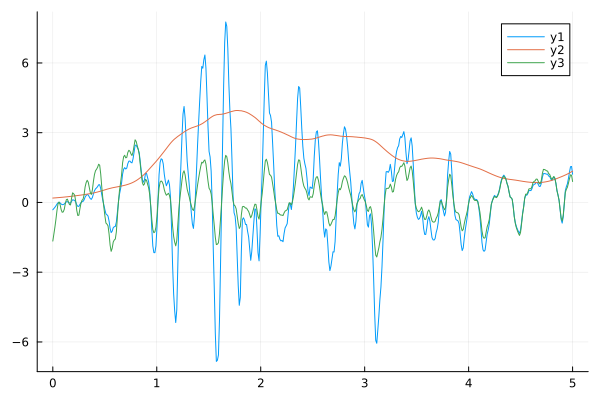

In [93]:
plot(time_range, y_data)
plot!(time_range,exp.(amplitude_gt))
plot!(time_range,carrier_gt)

In [94]:
#Exponentiate function 
struct MyExponential end

@node MyExponential Deterministic [ y, x ]   ## x: input,  y: output


@rule MyExponential(:y, Marginalisation) (m_x::UnivariateGaussianDistributionsFamily,) = begin 
    return LogNormal(mean(m_x), var(m_x))
end

@rule MyExponential(:x, Marginalisation) (m_y::UnivariateGaussianDistributionsFamily, m_x::UnivariateGaussianDistributionsFamily, ) = begin 
    dist = m_x    
    m_in, var_in = mean_var(m_x)
    l_pdf = (x) -> logpdf(m_y,exp.(x)) 
    pdf = x -> exp(l_pdf(x)-logpdf(dist,x)+1e-7)
    m,v = approximate_meancov(ghcubature(131),pdf,dist)

    if isnan(v) || isnan(m)
        log_pdf = x -> l_pdf(x) + logpdf(dist,x[1])  + 1e-7
        res = optimize(x -> -log_pdf(x), [m_in])
        mproxy = res.minimizer[1]
        dx  = x -> ForwardDiff.derivative(y -> -log_pdf(y),x)
        ddx = x -> ForwardDiff.derivative(dx, x)

        vproxy = cholinv(ddx(mproxy+tiny))
        m_ = mproxy 
        v_ = vproxy + 1e-6

        ksi = m_/v_ - m_in/var_in
        precision = clamp(1/v_ - 1/var_in, tiny,huge)

        if isnan(ksi) || isnan(precision)
            samples = rand(dist,3000)
            weights = exp.(l_pdf.(samples)) / sum(exp.(l_pdf.(samples)) )
            if any(isnan.(weights)) 
                m_ = sum(samples)/3000
                v_ = sum((samples .- m_).^2) /3000 
            else
                m_ = sum(weights .* samples)
                v_ = sum(weights .* (samples .- m_).^2)    
            end
            ksi = m_/v_ - m_in/var_in
            precision = clamp(1/v_ - 1/var_in, tiny,huge)
            
            return NormalWeightedMeanPrecision(ksi,precision)
        else
            return  NormalWeightedMeanPrecision(ksi,precision)
        end
    else
        return  NormalMeanVariance(m,v)
    end
end

@rule MyExponential(:x, Marginalisation) (m_y::ContinuousUnivariateLogPdf, m_x::UnivariateGaussianDistributionsFamily, ) = begin 
    dist = m_x    
    m_in, var_in = mean_var(m_x)
    l_pdf = (x) -> logpdf(m_y,exp.(x)) 
    pdf = x -> exp(l_pdf(x)-logpdf(dist,x)+1e-7)
    m,v = approximate_meancov(ghcubature(131),pdf,dist)

    if isnan(v) || isnan(m)
        log_pdf = x -> l_pdf(x) + logpdf(dist,x[1])  + 1e-7
        res = optimize(x -> -log_pdf(x), [m_in])
        mproxy = res.minimizer[1]
        dx  = x -> ForwardDiff.derivative(y -> -log_pdf(y),x)
        ddx = x -> ForwardDiff.derivative(dx, x)

        vproxy = cholinv(ddx(mproxy+tiny))
        m_ = mproxy 
        v_ = vproxy + 1e-6

        ksi = m_/v_ - m_in/var_in
        precision = clamp(1/v_ - 1/var_in, tiny,huge)

        if isnan(ksi) || isnan(precision)
            samples = rand(dist,3000)
            weights = exp.(l_pdf.(samples)) / sum(exp.(l_pdf.(samples)) )
            if any(isnan.(weights)) 
                m_ = sum(samples)/3000
                v_ = sum((samples .- m_).^2) /3000 
            else
                m_ = sum(weights .* samples)
                v_ = sum(weights .* (samples .- m_).^2)    
            end
            ksi = m_/v_ - m_in/var_in
            precision = clamp(1/v_ - 1/var_in, tiny,huge)
            
            return NormalWeightedMeanPrecision(ksi,precision)
        else
            return  NormalWeightedMeanPrecision(ksi,precision)
        end
    else
        return  NormalMeanVariance(m,v)
    end
end

In [95]:
#use Gaussian GaussHermiteCubature to approximate 
#Temporarily put here 
function ReactiveMP.prod(::ProdAnalytical, left::UnivariateGaussianDistributionsFamily, right::ContinuousUnivariateLogPdf) 
    #we use Gaussian Hermite Cubature here, not ProdAnalytical 
    meta = GaussHermiteCubature(121)
    m,v = ReactiveMP.approximate_meancov(meta, z -> exp(right.logpdf(z)), mean(left), var(left))
    return NormalMeanVariance(m,v)
end

function ReactiveMP.prod(::ProdAnalytical, left::ContinuousUnivariateLogPdf, right::UnivariateGaussianDistributionsFamily)
    meta = GaussHermiteCubature(121)
    m,v = ReactiveMP.approximate_meancov(meta, z -> exp(left.logpdf(z)), mean(right), var(right))
    return NormalMeanVariance(m,v)
end


# function ReactiveMP.prod(::ProdAnalytical, left::LogNormal, right::ContinuousUnivariateLogPdf) 
#     sample_left = rand(left,2000)
#     weights = [exp(logpdf(right,sample_left[i])) for i=1:length(sample_left)]
#     weight = weights / sum(weights)
#     m = sum(weight .* log.(sample_left))
#     v = sum(weight .* (log.(sample_left) .- m).^2)
#     return LogNormal(m,v)
# end

function ReactiveMP.prod(::ProdAnalytical, left::LogNormal, right::ContinuousUnivariateLogPdf) 
    sample_left = rand(left,500)
    f_samples_evaluated = [exp(logpdf(right,sample_left[i])) for i=1:length(sample_left)]
    p_samples_evaluated = [pdf(left,sample_left[i]) for i=1:length(sample_left)]
    m = sum(sample_left .* p_samples_evaluated .* f_samples_evaluated)
    v = sum((sample_left .- m).^2 .* p_samples_evaluated .* f_samples_evaluated)
    if isnan(v)
        k = sample_left .* p_samples_evaluated .* f_samples_evaluated
        for i =1:length(k) 
            if isnan(k[i])
                sample_left[i] = 1e-2
            end
        end
        f_samples_evaluated = [exp(logpdf(right,sample_left[i])) for i=1:length(sample_left)]
        p_samples_evaluated = [pdf(left,sample_left[i]) for i=1:length(sample_left)]
        m = sum(sample_left .* p_samples_evaluated .* f_samples_evaluated)
        v = sum((sample_left .- m).^2 .* p_samples_evaluated .* f_samples_evaluated)
    end
    return LogNormal(m,v)
end


In [96]:
@rule typeof(*)(:A, Marginalisation) (m_out::UnivariateGaussianDistributionsFamily, m_A::UnivariateGaussianDistributionsFamily, m_in::LogNormal, meta::TinyCorrection) = begin 
    #mean_in and var_in come from m_A
    backward_A = @call_rule typeof(*)(:A, Marginalisation) (m_out = m_out, m_in = m_in, meta=meta)
    mean_in, var_in = mean_var(m_A)
    dist = m_A 
    pdf = x -> exp(backward_A(x)-logpdf(dist,x)+1e-7)
    m,v = approximate_meancov(ghcubature(121),pdf,dist)

    if isnan(v) || isnan(m)
        log_pdf = x -> backward_A(x) + logpdf(dist,x[1])  + 1e-7
        res = optimize(x -> -log_pdf(x), [mean_in])
        mproxy = res.minimizer[1]
        dx  = x -> ForwardDiff.derivative(y -> -log_pdf(y),x)
        ddx = x -> ForwardDiff.derivative(dx, x)

        vproxy = cholinv(ddx(mproxy+tiny))
        m_ = mproxy 
        v_ = vproxy + 1e-6

        ksi = m_/v_ - mean_in/var_in
        precision = clamp(1/v_ - 1/var_in, tiny,huge)

        if isnan(ksi) || isnan(precision)
            samples = rand(dist,3000)
            weights = exp.(backward_A.(samples)) / sum(exp.(backward_A.(samples)) )
            if any(isnan.(weights)) 
                m_ = sum(samples)/3000
                v_ = sum((samples .- m_).^2) /3000
            else
                m_ = sum(weights .* samples)
                v_ = sum(weights .* (samples .- m_).^2)    
            end
            ksi = m_/v_ - mean_in/var_in
            precision = clamp(1/v_ - 1/var_in, tiny,huge)
            
            return NormalWeightedMeanPrecision(ksi,precision)
        else
            return  NormalWeightedMeanPrecision(ksi,precision)
        end
    else
        return  NormalMeanVariance(m,v)
    end
end

@rule typeof(*)(:A, Marginalisation) (m_out::PointMass, m_A::UnivariateGaussianDistributionsFamily, m_in::LogNormal, meta::TinyCorrection) = begin 
    backward_A = (x) -> -log(abs(x)) + logpdf(m_in,mean(m_out)/x)
    mean_in, var_in = mean_var(m_A)
    dist = m_A 
    pdf = x -> exp(backward_A(x)-logpdf(dist,x)+1e-7)
    m,v = approximate_meancov(ghcubature(121),pdf,dist)

    if isnan(v) || isnan(m)
        log_pdf = x -> backward_A(x[1]) + logpdf(dist,x[1])  + 1e-7
        res = optimize(x -> -log_pdf(x), [mean_in])
        mproxy = res.minimizer[1]
        dx  = x -> ForwardDiff.derivative(y -> -log_pdf(y),x)
        ddx = x -> ForwardDiff.derivative(dx, x)

        vproxy = cholinv(ddx(mproxy+tiny))
        m_ = mproxy 
        v_ = vproxy + 1e-6

        ksi = m_/v_ - mean_in/var_in
        precision = clamp(1/v_ - 1/var_in, tiny,huge)

        if isnan(ksi) || isnan(precision)
            samples = rand(dist,3000)
            weights = exp.(backward_A.(samples)) / sum(exp.(backward_A.(samples)) )
            if any(isnan.(weights)) 
                m_ = sum(samples)/3000
                v_ = sum((samples .- m_).^2) /3000
            else
                m_ = sum(weights .* samples)
                v_ = sum(weights .* (samples .- m_).^2)    
            end
            ksi = m_/v_ - mean_in/var_in
            precision = clamp(1/v_ - 1/var_in, tiny,huge)
            
            return NormalWeightedMeanPrecision(ksi,precision)
        else
            return  NormalWeightedMeanPrecision(ksi,precision)
        end
    else
        return  NormalMeanVariance(m,v)
    end
end

@rule typeof(*)(:A, Marginalisation) (m_out::PointMass, m_in::UnivariateGaussianDistributionsFamily, meta::TinyCorrection) = begin 
    backward_A = (x) -> -log(abs(x)) + logpdf(m_in,mean(m_out)/x)
    return ContinuousUnivariateLogPdf(backward_A)
end

In [103]:
#GP Amplitude Demodulation model 
@model function gp_AmplitudeDemodulation(n, P∞_amplitude,A_amplitude,Q_amplitude,P∞_carrier,A_carrier,Q_carrier,H)
    y = datavar(Float64,n)
    f = randomvar(n)
    z = randomvar(n)
    g = randomvar(n)
    c = randomvar(n)
    # w = randomvar(n)
    d = randomvar(n)
    
    f_0 ~ MvNormalMeanCovariance(zeros(length(H)), P∞_amplitude)
    c_0 ~ MvNormalMeanCovariance(zeros(length(H)), P∞_carrier)
    f_prev = f_0
    c_prev = c_0
    for i=1:n 
        f[i] ~ MvNormalMeanCovariance(A_amplitude[i] * f_prev, Q_amplitude[i])
        z[i] ~ NormalMeanVariance(dot(H , f[i]), 0.6)
        g[i] ~ MyExponential(z[i]) where {pipeline = RequireMessage(x = NormalMeanPrecision(0., 0.5))}

        c[i] ~ MvNormalMeanCovariance(A_carrier[i] * c_prev, Q_carrier[i])
        d[i] ~ NormalMeanVariance(dot(H, c[i]), 0.6) 

        y[i] ~ (*)(d[i],g[i]) where {meta = TinyCorrection(), pipeline = RequireMessage(A = NormalMeanPrecision(.5, 0.5))}
        f_prev = f[i]
        c_prev = c[i]
    end
end

In [104]:
#### compute matrices for the state-space model corresponding to Matern-52 kernel ######
θ_amplitude = [.8, 1.]; # store [l, σ²]
θ_carrier = [0.05, .5]; # store [l, σ²]

Δt = [time_range[2] - time_range[1]]; # time difference
append!(Δt, time_range[2:end] - time_range[1:end-1]);

λ_amplitude = sqrt(5)/θ_amplitude[1];
λ_carrier = sqrt(5)/θ_carrier[1];

L = [0., 0., 1.];
H = [1., 0., 0.];

F_amplitude = [0. 1. 0.; 0. 0. 1.;-λ_amplitude^3 -3λ_amplitude^2 -3λ_amplitude]
F_carrier = [0. 1. 0.; 0. 0. 1.;-λ_carrier^3 -3λ_carrier^2 -3λ_carrier]

Qc_amplitude = 16/3 * θ_amplitude[2] * λ_amplitude^5;
Qc_carrier = 16/3 * θ_carrier[2] * λ_carrier^5;

Imat = diageye(3) ; 

vec_P_amplitude = inv(kron(Imat,F_amplitude) + kron(F_amplitude,Imat)) * vec(-L * Qc_amplitude * L'); 
vec_P_carrier = inv(kron(Imat,F_carrier) + kron(F_carrier,Imat)) * vec(-L * Qc_carrier * L'); 

P∞_amplitude = reshape(vec_P_amplitude,3,3);
P∞_carrier = reshape(vec_P_carrier,3,3);

A_amplitude = [exp(F_amplitude * i) for i in Δt]; 
Q_amplitude = [P∞_amplitude - i*P∞_amplitude*i' for i in A_amplitude];

A_carrier = [exp(F_carrier * i) for i in Δt]; 
Q_carrier = [P∞_carrier - i*P∞_carrier*i' for i in A_carrier];

In [105]:
nits =20

iresult = inference(
    model = gp_AmplitudeDemodulation(length(y_data), P∞_amplitude,A_amplitude,Q_amplitude, P∞_carrier,A_carrier,Q_carrier,H),
    iterations = nits, 
    data  = (y = y_data,),
    returnvars = (f = KeepEach(),c = KeepEach(),),
    options = (limit_stack_depth=400,),
    showprogress = false
)

Inference results:
  Posteriors       | available for (f, c)


In [106]:
mgp = mean.(iresult.posteriors[:f][end]) |> slicedim(1)
vgp = var.(iresult.posteriors[:f][end]) |> slicedim(1)
expvgp = exp.( mgp .+ vgp)
expmgp = exp.(mgp);

┌ Info: Saved animation to /Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/PAD.gif
└ @ Plots /Users/nguyenhuuminhhoang/.julia/packages/Plots/QZRtR/src/animation.jl:156


Plots.AnimatedGif("/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/PAD.gif")
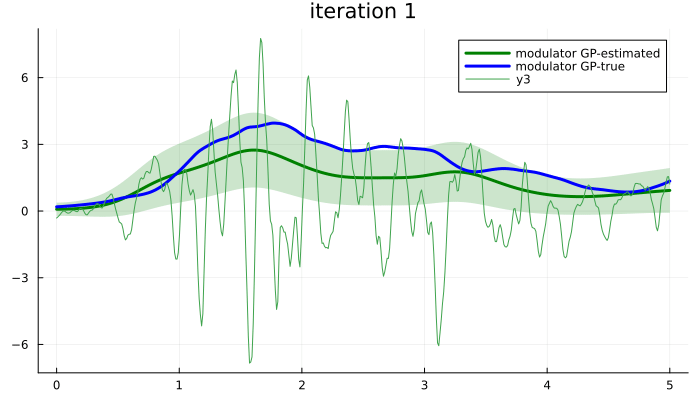

In [107]:
#create animation
anim = @animate for i=1:nits
    mgp = mean.(iresult.posteriors[:f][i]) |> slicedim(1)
    vgp = var.(iresult.posteriors[:f][i]) |> slicedim(1)
    expvgp = exp.( mgp .+ vgp)
    expmgp = exp.(mgp);
    plot(time_range,expmgp,ribbon=sqrt.(expvgp),linewidth=3.0,label="modulator GP-estimated",fillalpha=0.2,color=:green, size = (700, 400),title="iteration $i")
    plot!(time_range,exp.(amplitude_gt), label="modulator GP-true",linewidth=3.0,color=:blue)
    plot!(time_range, y_data)
end

gif(anim,"PAD.gif",fps=1)

┌ Info: Saved animation to /Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/PAD_carrier.gif
└ @ Plots /Users/nguyenhuuminhhoang/.julia/packages/Plots/QZRtR/src/animation.jl:156


Plots.AnimatedGif("/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/PAD_carrier.gif")
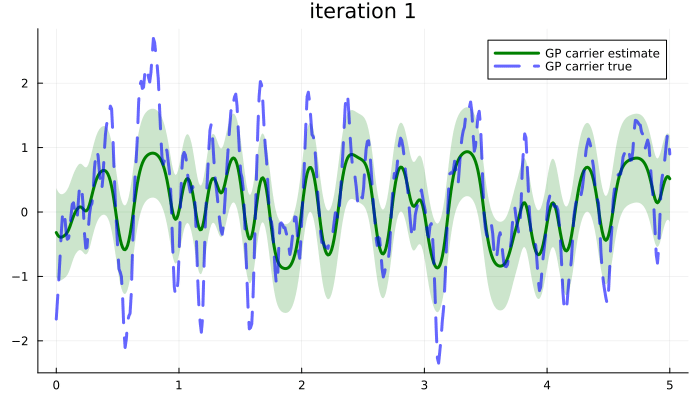

In [108]:
#create animation
anim = @animate for i=1:nits
    mcarriers = mean.(iresult.posteriors[:c][i]) |> slicedim(1)
    vcarriers = var.(iresult.posteriors[:c][i]) |> slicedim(1);
    plot(time_range, mcarriers,ribbon=sqrt.((vcarriers)),label="GP carrier estimate",linewidth=3.0, fillalpha=0.2, color="green", size=(700,400),title="iteration $i")
    plot!(time_range, carrier_gt,linewidth=3.0, color="blue", label="GP carrier true",alpha=0.6,ls=:dash)
end

gif(anim,"PAD_carrier.gif",fps=1)

## Real Data 

In [109]:
using WAV, MAT

In [110]:
datapath = "/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/data/"
file = matopen(datapath*"filter_outputs.mat")
FilteredOutput = read(file, "data")

X, fs = wavread(datapath*"data_05-Bubblingstream.wav");
fs = Float64(fs);

In [111]:
data = FilteredOutput[:,2];
NumberOfSamples = length(data);
signal_time = 1/fs * (NumberOfSamples-1);
signaltime_range = collect(0.:1/fs:signal_time); 
data = data / sqrt(var(data));

# #Let's use 1 second of the signal 
NumberOfTruncatedSignalSamples = Int(round(fs+1))
y_data = data[1:NumberOfTruncatedSignalSamples] 
t_data = collect(0.:1/fs:(NumberOfTruncatedSignalSamples-1) / fs);

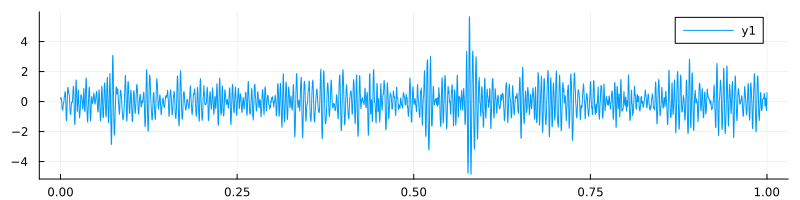

In [112]:
from = 1 
to = length(y_data)
skip = 1

plot(t_data,y_data,size = (800,200))

In [151]:
#GP Amplitude Demodulation model 
@model function gp_AmplitudeDemodulation(n, P∞_amplitude,A_amplitude,Q_amplitude,P∞_carrier,A_carrier,Q_carrier,H)
    y = datavar(Float64,n)
    f = randomvar(n)
    z = randomvar(n)
    g = randomvar(n)
    c = randomvar(n)
    # w = randomvar(n)
    d = randomvar(n)
    
    f_0 ~ MvNormalMeanCovariance(zeros(length(H)), P∞_amplitude)
    c_0 ~ MvNormalMeanCovariance(zeros(length(H)), P∞_carrier)
    f_prev = f_0
    c_prev = c_0
    for i=1:n 
        f[i] ~ MvNormalMeanCovariance(A_amplitude[i] * f_prev, Q_amplitude[i])
        z[i] ~ NormalMeanVariance(dot(H , f[i]), 0.6)
        g[i] ~ MyExponential(z[i]) where {pipeline = RequireMessage(x = NormalMeanPrecision(0., 0.5))}

        c[i] ~ MvNormalMeanCovariance(A_carrier[i] * c_prev, Q_carrier[i])
        d[i] ~ NormalMeanVariance(dot(H, c[i]), 0.6) 

        y[i] ~ (*)(d[i],g[i]) where {meta = TinyCorrection(), pipeline = RequireMessage(A = NormalMeanPrecision(0., 0.5))}
        f_prev = f[i]
        c_prev = c[i]
    end
end

In [152]:
#### compute matrices for the state-space model corresponding to Matern-52 kernel ######
θ_amplitude = [0.015, 1.]; # store [l, σ²]
θ_carrier = [0.001, .5]; # store [l, σ²]

Δt = [t_data[2] - t_data[1]]; # time difference
append!(Δt, t_data[2:end] - t_data[1:end-1]);

λ_amplitude = sqrt(5)/θ_amplitude[1];
λ_carrier = sqrt(5)/θ_carrier[1];

L = [0., 0., 1.];
H = [1., 0., 0.];

F_amplitude = [0. 1. 0.; 0. 0. 1.;-λ_amplitude^3 -3λ_amplitude^2 -3λ_amplitude]
F_carrier = [0. 1. 0.; 0. 0. 1.;-λ_carrier^3 -3λ_carrier^2 -3λ_carrier]

Qc_amplitude = 16/3 * θ_amplitude[2] * λ_amplitude^5;
Qc_carrier = 16/3 * θ_carrier[2] * λ_carrier^5;

Imat = diageye(3) ; 

vec_P_amplitude = inv(kron(Imat,F_amplitude) + kron(F_amplitude,Imat)) * vec(-L * Qc_amplitude * L'); 
vec_P_carrier = inv(kron(Imat,F_carrier) + kron(F_carrier,Imat)) * vec(-L * Qc_carrier * L'); 

P∞_amplitude = reshape(vec_P_amplitude,3,3);
P∞_carrier = reshape(vec_P_carrier,3,3);

A_amplitude = [exp(F_amplitude * i) for i in Δt]; 
Q_amplitude = [P∞_amplitude - i*P∞_amplitude*i' for i in A_amplitude];

A_carrier = [exp(F_carrier * i) for i in Δt]; 
Q_carrier = [P∞_carrier - i*P∞_carrier*i' for i in A_carrier];

In [153]:
nits =3

iresult = inference(
    model = gp_AmplitudeDemodulation(length(y_data), P∞_amplitude,A_amplitude,Q_amplitude, P∞_carrier,A_carrier,Q_carrier,H),
    iterations = nits, 
    data  = (y = y_data,),
    returnvars = (f = KeepLast(),c = KeepLast(),),
    options = (limit_stack_depth=100,),
    showprogress = false
)

Inference results:
  Posteriors       | available for (f, c)


In [154]:
mgp = mean.(iresult.posteriors[:f]) |> slicedim(1)
vgp = var.(iresult.posteriors[:f]) |> slicedim(1)
expvgp = exp.( mgp .+ vgp)
expmgp = exp.(mgp);

mcarriers = mean.(iresult.posteriors[:c]) |> slicedim(1)
vcarriers = var.(iresult.posteriors[:c]) |> slicedim(1);

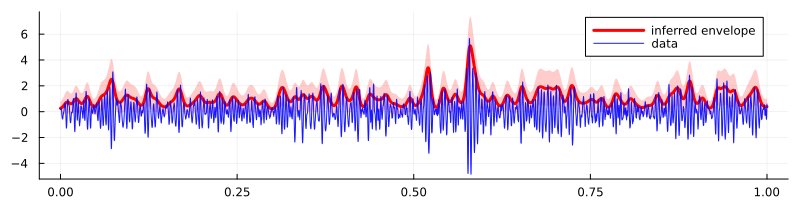

In [155]:
from = 1
to = length(y_data)
skip = 1
plot(t_data[from:skip:to],expmgp[from:skip:to],ribbon=sqrt.(expvgp),linewidth=3.0,label="inferred envelope",fillalpha=0.2,color=:red, size=(800,200))
plot!(t_data[from:skip:to],y_data[from:skip:to], label="data",alpha=0.9,ms=3, color=:blue)

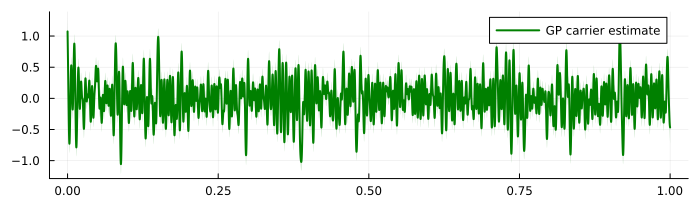

In [156]:
plot(t_data[from:skip:to], mcarriers[from:skip:to],ribbon=sqrt.((vcarriers[from:skip:to])),label="GP carrier estimate",linewidth=2.0, fillalpha=0.2, color="green", size=(700,200))